In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import numpy as np
from src.model import CIFAR10
from src.aa import fgsm_attack

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cuda')
print(f"Device = {device}")

Device = cuda


In [3]:
train_data = datasets.CIFAR10(root="./data/cifar10/",
                            train=True,
                            download=True,
                            transform=transforms.ToTensor()
                            )

test_data = datasets.CIFAR10(root="./data/cifar10/",
                           train=False,
                           download=True,
                           transform=transforms.ToTensor()
                           )

print(len(train_data), len(test_data))

60000 10000


In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=1, shuffle=True)

In [5]:

epsilons = [0, .05, .1, .15, .2, .25, .3]

In [6]:
model = CIFAR10.BNet().to(device)
model.load_state_dict(torch.load('./checkpoints/cifar10_bnet.pth')['model'])
model.eval()

BNet(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(5, 9, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(9, 13, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=637, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [7]:
def test(model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        data.requires_grad = True
        
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        
        if init_pred.item() != target.item():
            continue
        
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        
        output = model(perturbed_data)
        
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    return final_acc, adv_examples

In [8]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9842 / 10000 = 0.9842
Epsilon: 0.05	Test Accuracy = 8246 / 10000 = 0.8246
Epsilon: 0.1	Test Accuracy = 4039 / 10000 = 0.4039
Epsilon: 0.15	Test Accuracy = 1446 / 10000 = 0.1446
Epsilon: 0.2	Test Accuracy = 416 / 10000 = 0.0416
Epsilon: 0.25	Test Accuracy = 94 / 10000 = 0.0094
Epsilon: 0.3	Test Accuracy = 33 / 10000 = 0.0033


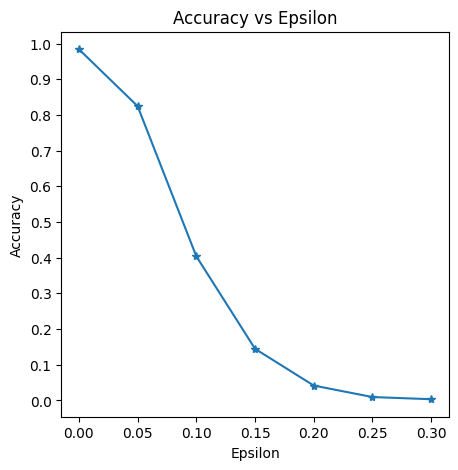

In [9]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [10]:
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

AttributeError: 'numpy.ndarray' object has no attribute 'clone'

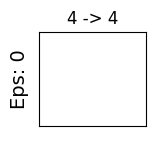

In [11]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        plt.imshow(ex.clone().detach().numpy())
plt.tight_layout()
plt.show()

